In [1]:
from LIMxCMBL.init import *
from scipy.integrate import simpson, trapezoid, cumulative_trapezoid
import pickle
from tqdm import tqdm, trange

from LIMxCMBL.experiments import *
import matplotlib.pyplot as plt 

/home/users/delon/.local/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


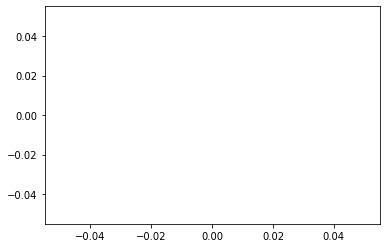

In [2]:
plt.plot()
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 10,
    "font.family" : "serif",
    'figure.constrained_layout.use':True,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'hatch.linewidth':0.1,
    'figure.figsize': (6, 6/1.618),
    'figure.constrained_layout.use': True,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
})


In [3]:
e_order = ['CHIME',
          'HETDEX',
          'COMAP',
        'CCAT-prime',
           'SPHEREx',]

e_colors = {
    'CHIME': '#8932B8',
    'HETDEX': '#3C44AA',
    'COMAP': '#5E7C16',
    'SPHEREx': '#B02E26',
    'CCAT-prime':'#F9801D',
}

In [4]:
kpar_funds = []
for experiment in e_order:
    zmin = experiments[experiment]['zmin']
    zmax = experiments[experiment]['zmax']
    chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
    chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
    
    kpar_fundamental = 2*np.pi/(chimax - chimin)
    kpar_funds += [[kpar_fundamental, experiment]]
    
kpar_funds = list(reversed(sorted(kpar_funds)))

In [5]:
import matplotlib.patheffects as pe

In [6]:
delta_logell = np.mean(np.diff(np.log(ells)))

In [7]:
logell_edges = np.log(ells)[0] - delta_logell/2 + delta_logell * np.arange(len(ells))

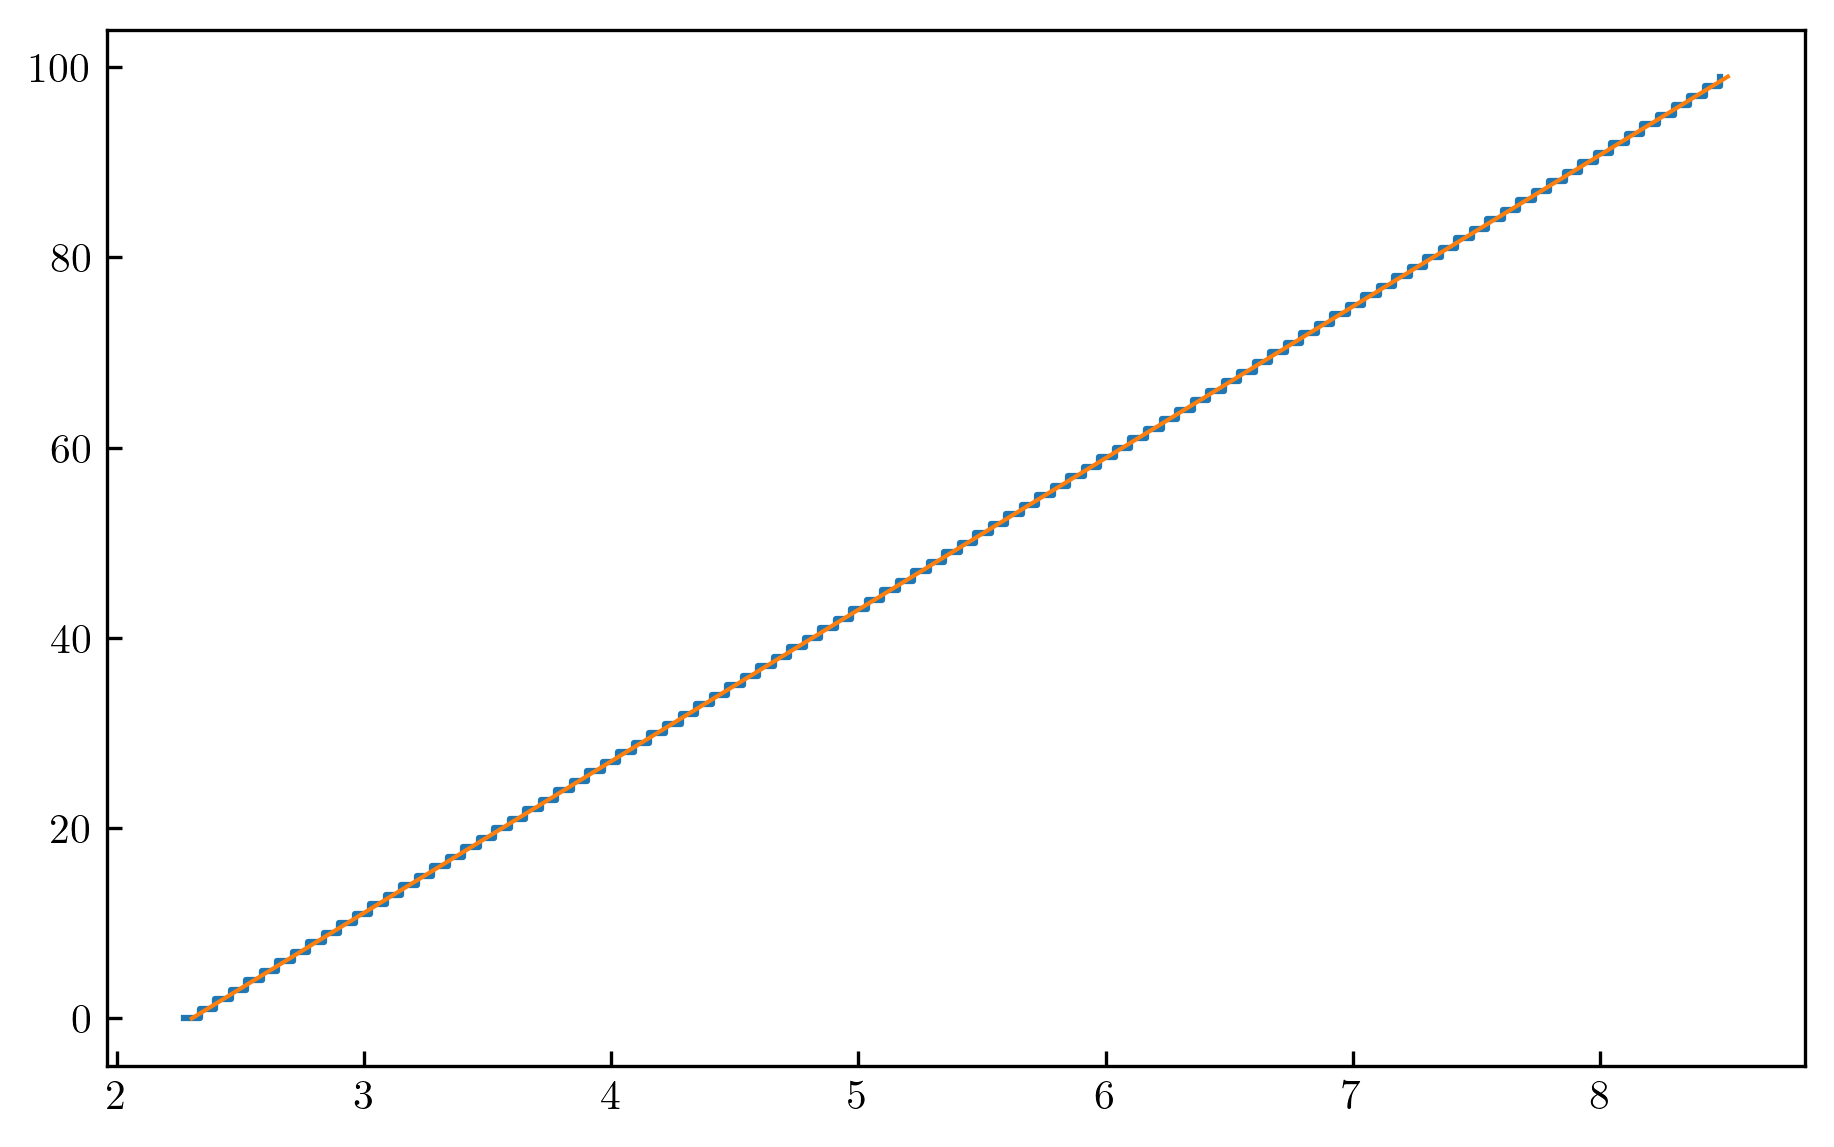

In [8]:
plt.figure(dpi = 300)
plt.step(logell_edges, np.arange(len(ells)), where='post')
plt.plot(np.log(ells), np.arange(len(ells)), lw=1)

In [9]:
from matplotlib.lines import Line2D


In [10]:
plt_left = plt.rcParams['figure.subplot.left']
plt_right = plt.rcParams['figure.subplot.right']
plt_cntr = (plt_left + plt_right) / 2


/tmp/ipykernel_110991/1019165179.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad = 0.0)


21.774558269595076
5.38918454251561
1.2341717617901535
0.860834099605602
0.865130790949858


/tmp/ipykernel_110991/1019165179.py:12: RuntimeWarning: divide by zero encountered in divide
  return 2*np.pi/(theta * 1/60 * np.pi/180)
/tmp/ipykernel_110991/1019165179.py:12: RuntimeWarning: divide by zero encountered in divide
  return 2*np.pi/(theta * 1/60 * np.pi/180)


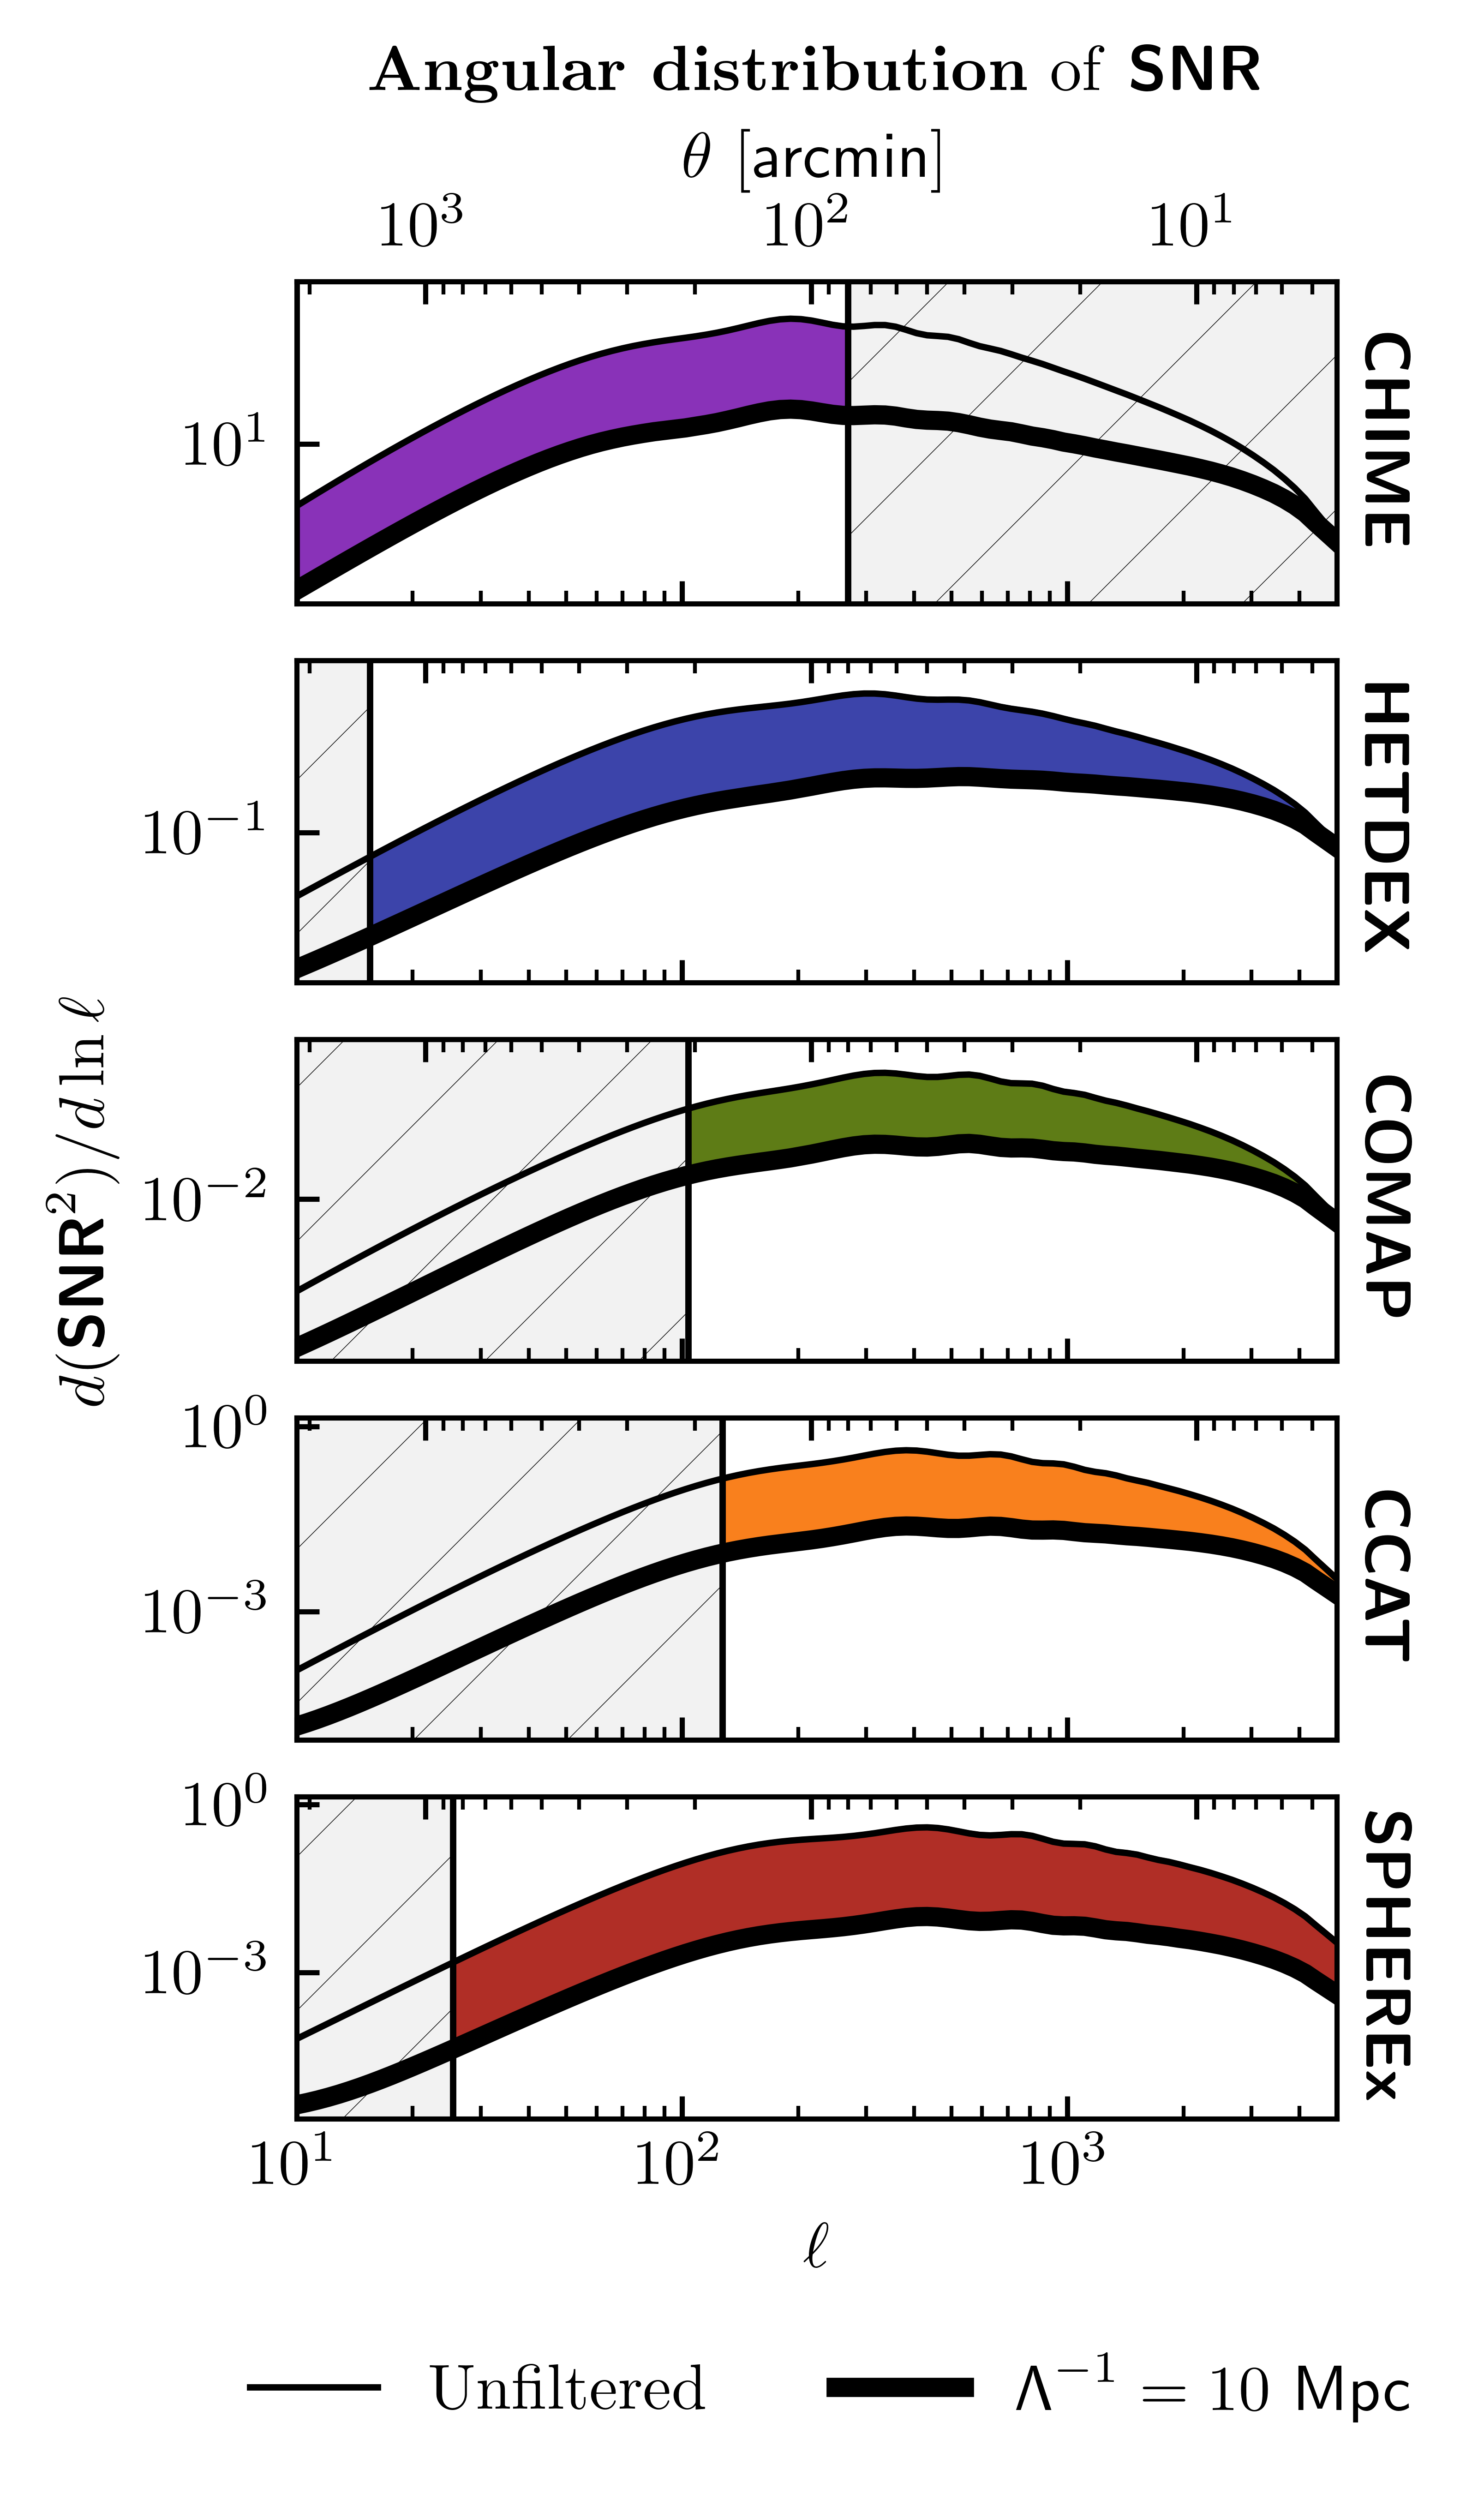

In [11]:
fig, meta_axs = plt.subplots(nrows=5, ncols=1, 
                             figsize = (2.5, 4.2), facecolor = 'w', dpi = 1000,
#                              sharey=True,
                             sharex=True,
                            )
plt.tight_layout(pad = 0.0)

def ell_to_theta_arcmin(ell):
    return 2*np.pi/ell * 180/np.pi * 60/1

def theta_arcmin_to_ell(theta):
    return 2*np.pi/(theta * 1/60 * np.pi/180)

for e_idx, experiment in enumerate(e_order):
#     if(experiment == 'SPHEREx'):
#         continue
    ax = meta_axs[e_idx]
    #metadata
    zmin = experiments[experiment]['zmin']
    zmax = experiments[experiment]['zmax']
    line_str = experiments[experiment]['line_str']
    
    Omega_field  =  np.array(experiments[experiment]['Omega_field'].to(u.rad**2)) #rad^2
    chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
    chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
    
    kpar_fundamental = 2*np.pi/(chimax - chimin)

    ell_fundamental = np.sqrt((2*np.pi)**2 / Omega_field)
    ell_fundamental = max(np.array(ell_fundamental), 10)

    ell_max_survey = np.sqrt((np.pi)**2 / experiments[experiment]['Omega_pix'].to(u.rad**2).value)
    ell_max_survey = np.array(ell_max_survey)
    c = e_colors[experiment]

    
    N0_fname = 'so'

    inp_fname = '/scratch/users/delon/LIMxCMBL/SNR_011.007_N0_'+N0_fname+'_'
    with open(inp_fname+experiment+'_full.pkl', 'rb') as f:
        SNR2_per_mode_full = pickle.load(f)

    _Lambdas = np.array(sorted(list(SNR2_per_mode_full.keys())))
    
    full_dist = SNR2_per_mode_full[0] * ells ** 2 * Omega_field / 2 / np.pi
    filtered_dist = SNR2_per_mode_full[_Lambdas[-1]] * ells ** 2 * Omega_field / 2 / np.pi
    
    
    ax.fill_between(ells, filtered_dist, full_dist, color=c, alpha = 1)
    ax.plot(ells,
             full_dist,
         c='k',
            ls='-',
            lw=1,
            label='Unfiltered',
        )
    ax.plot(ells,
         filtered_dist,
         c='k',
         ls='-',
             lw=3,
            label=r'$\Lambda^{-1} = 10\ [{\sf Mpc}]$'
        )

    #quick sanity
    _idxs = np.where((ells >= ell_fundamental) & (ells <= ell_max_survey))
    asdf = trapezoid(x = np.log(ells)[_idxs],
                     y = full_dist[_idxs])
    print(np.sqrt(asdf))
    #####
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(10, 5000)
    ax.set_ylim(None, ax.get_ylim()[-1]*2)
    ax.axvspan(0, ell_fundamental, alpha=1, facecolor="0.95", hatch='/',
                rasterized=True, linewidth=0, edgecolor="k")

    ax.axvline(ell_fundamental, linewidth=1,color='k')
    
    ax.axvspan(ell_max_survey, 5000, alpha=1, facecolor="0.95", hatch='/',
                rasterized=True, linewidth=0, edgecolor="k")

    ax.axvline(ell_max_survey, linewidth=1,color='k')    
    
    _etxt = experiment
    if(experiment == 'CCAT-prime'):
        _etxt = 'CCAT'
    ax.text(x=1.015, y=0.5, s = r'\textsf{\textbf{%s}}'%(_etxt),
           transform=ax.transAxes,
           rotation = -90,
           verticalalignment='center')
    
    
    ax_top = ax.secondary_xaxis('top', functions=(ell_to_theta_arcmin, theta_arcmin_to_ell), zorder=10)
    if(e_idx == 0):
        ax_top.set_xlabel(r'$\theta$ [{\sf arcmin}]')
    if(e_idx != 0):
        ax_top.tick_params(labeltop=False)
meta_axs[-1].set_xlabel(r'$\ell$')
meta_axs[2].set_ylabel(r'$d(\textsf{\textbf{SNR}}^2)/d \ln \ell$')
meta_axs[0].set_title(r'\textbf{Angular distribution} of \textsf{\textbf{SNR}}', fontsize=10)

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [
    Line2D([0], [0], color='k', lw=1, ls='-', label='Unfiltered'),
    Line2D([0], [0], color='k', lw=3, label=r'${\sf\Lambda}^{-1}=10\ {\sf Mpc}$'),
#     Patch(facecolor="0.95", hatch='/', edgecolor="k", lw=1, label=r'Inaccessible')
]

fig.legend(handles=legend_elements, 
           loc='upper center',
           bbox_to_anchor=(plt_cntr, -0.05),
           frameon=False,
           ncol=3)
thetas_arcmin = 2*np.pi/ells * 180 / np.pi * 60 / 1

plt.savefig('figures/011.007.dSNR_dlnl_SO.pdf', bbox_inches='tight')